In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, compose
from hydra.utils import instantiate
import pyrootutils
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from torch.nn import functional as F
from torch.optim import Adam
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel 
from tqdm import tqdm
from probes import *
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

/Users/ic0523/miniconda3/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup(model='base_vlm', task='base_vlm_task'):
    '''
    Annoying but necessary function to setup the hydra environment within a jupyter notebook.
    '''
    pyrootutils.setup_root('.', dotenv=True, pythonpath=True)
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path='config')
    cfg = compose(config_name='run', overrides=[f'model={model}', f'task={task}'])
    return cfg

class ImageDataset(Dataset):
    def __init__(self, df, target_feature):
        ys = torch.tensor(df[target_feature].values.astype(int)-1)
        self.ys = F.one_hot(ys, ys.max()+1).to(dtype=torch.float32)
        self.xs = torch.stack([TF.to_tensor(Image.open(p)) for p in df.path.values])
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]

#### Let's start with CLIP!

In [4]:
def fit_probe(probe, xs, ys, n_epochs=10, pool=False, log_interval=1000):
    '''Fit a probe to decode a target variable y from an image embedding x for n_epochs.

    Args:
        probe: The probe to be trained.
        xs: The image embeddings.
        ys: The target variable.
        n_epochs: The number of epochs to train the probe for.
        pool: Whether to use a pooling layer before the probe.
    '''
    all_pooled_reps = []
    all_accuracies = []
    for i in range(n_epochs):
        optimizer.zero_grad()
        # If we need to pool token embeddings, do so and save the pooled representations.
        if pool:
            pooled_rep, y_hat = probe(xs)
            y_hat = F.softmax(y_hat, dim=1)
            all_pooled_reps.append(pooled_rep)
        # Otherwise, just apply the probe.
        else:
            y_hat = F.softmax(probe(xs), dim=1)
        loss = F.binary_cross_entropy(y_hat, ys)
        acc = (y_hat.argmax( 1) == ys.argmax(1)).float().mean()
        all_accuracies.append(acc)
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print(f'    Epoch {i} loss: {loss.item():0.8f}   acc: {acc.item():0.8f}')
    return probe, all_pooled_reps, all_accuracies

# Load the environment and the dataset.
batch_size = 1
cfg = setup(task='counting')
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# First compute the image embeddings and inspect their shape.
print('Computing embeddings...')
targets = [] 
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model.get_image_features(**inputs)
        embs.append(img_emb)
        targets.append(ys)
xs = torch.cat(embs)
ys = torch.cat(targets)
print(f'    Embeddings shape: {xs.shape}')

# Now only train an MLP to predict the number of objects from the CLIP embedding.
print('Fitting probe...')
probe = CampbellMLP(xs.shape[-1], xs.shape[-1], ys.shape[-1], dropout_prob=0.2, single_span=True)
optimizer = Adam(probe.parameters(), lr=5e-4)
probe, _, accuracies = fit_probe(probe, xs, ys, n_epochs=5000, pool=False, log_interval=1000)

Loading task metadata from /Users/ic0523/Documents/projects/misc/ACSS-2024/data/counting/metadata.csv...
Computing embeddings...


100%|██████████| 5000/5000 [04:34<00:00, 18.24it/s]


    Embeddings shape: torch.Size([5000, 512])
Fitting probe...
    Epoch 0 loss: 0.35753235   acc: 0.08420000
    Epoch 1000 loss: 0.10610133   acc: 0.76880002
    Epoch 2000 loss: 0.08932663   acc: 0.79740000
    Epoch 3000 loss: 0.08294439   acc: 0.81400001
    Epoch 4000 loss: 0.08060820   acc: 0.82440001
    Epoch 5000 loss: 0.07795428   acc: 0.82660002
    Epoch 6000 loss: 0.08063821   acc: 0.82220000
    Epoch 7000 loss: 0.07814789   acc: 0.82380003
    Epoch 8000 loss: 0.07838350   acc: 0.82040000
    Epoch 9000 loss: 0.08000282   acc: 0.81940001


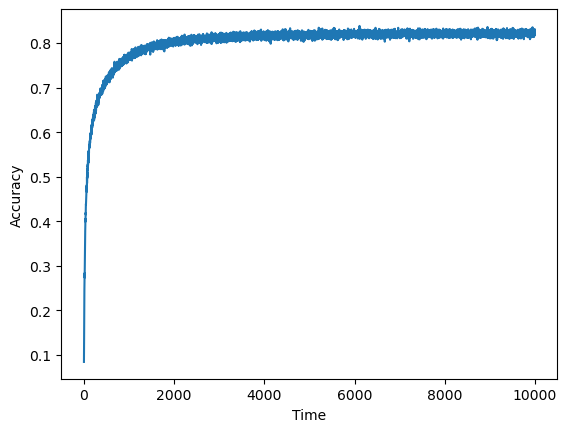

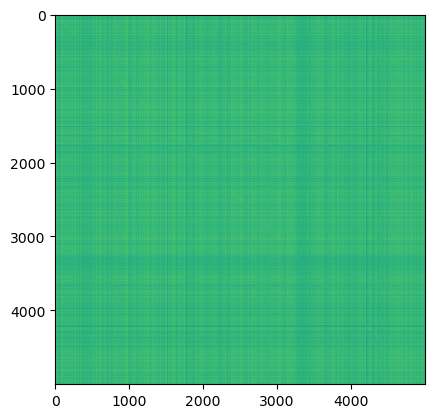

In [16]:
# Plot performance over time.
performance_df = pd.DataFrame({'Accuracy': np.array(accuracies)})
performance_df['Time'] = np.arange(len(accuracies))
sns.lineplot(data=performance_df, x='Time', y='Accuracy')
plt.show()

# Plot the similarity structure of the embeddings.
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].cpu().numpy()
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs, xs)
plt.imshow(sim_mat)

#### Probing for DINOv2 (without pooling).

In [17]:
# Load the environment and the dataset.
batch_size = 1
cfg = setup()
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# First compute the image embeddings and inspect their shape.
print('Computing embeddings...')
targets = []
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model.get_image_features(**inputs)
        embs.append(img_emb)
        targets.append(ys)
xs = torch.cat(embs).mean(1)
ys = torch.cat(targets)
print(f'    Embeddings shape: {xs.shape}')

# Now only train an MLP to predict the number of objects from the CLIP embedding.
print('Fitting probe...')
probe = CampbellMLP(xs.shape[-1], xs.shape[-1], ys.shape[-1], dropout_prob=0.2, single_span=True)
optimizer = Adam(probe.parameters(), lr=5e-4)
probe, _, accuracies = fit_probe(probe, xs, ys, n_epochs=1000, pool=True, log_interval=50)

Loading task metadata from /Users/ic0523/Documents/projects/misc/ACSS-2024/data/counting/metadata.csv...
Computing embeddings...


100%|██████████| 5000/5000 [03:54<00:00, 21.36it/s]


    Embeddings shape: torch.Size([5000])
Fitting probe...


ValueError: too many values to unpack (expected 2)

In [ ]:
# Plot performance over time.
performance_df = pd.DataFrame({'Accuracy': accuracies})
performance_df['Time'] = np.arange(len(accuracies))
performance_df['Accuracy'] = pd.rolling_mean(performance_df['Accuracy'], window=100) # Smooth
sns.lineplot(data=performance_df, x='Time', y='Accuracy')

# Plot the similarity structure of the embeddings.
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].cpu().numpy()
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs, xs)
plt.imshow(sim_mat)

#### Probing for DINOv2 (with pooling).

In [ ]:
class Probe(torch.nn.Module):
    def __init__(self, pooler, probe_mlp):
        super().__init__()
        self.pooler = pooler
        self.probe = probe_mlp
    def forward(self, x):
        xs = self.pooler(x)
        ys = self.probe(xs)
        return xs, ys

# Load the environment and the dataset.
batch_size = 1
cfg = setup()
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# First compute the image embeddings and inspect their shape.
print('Computing embeddings...')
targets = []
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model.get_image_features(**inputs)
        embs.append(img_emb)
        targets.append(ys)
xs = torch.cat(embs)
ys = torch.cat(targets)
print(f'    Embeddings shape: {embs.shape}')

# Now only train an MLP to predict the number of objects from the CLIP embedding.
print('Fitting probe...')
pooler = AttentionPooler(xs.shape[-1], xs.shape[-1])
mlp = CampbellMLP(xs.shape[-1], xs.shape[-1], ys.shape[-1], dropout_prob=0.2, single_span=True)
probe = Probe(pooler, mlp)
optimizer = Adam(probe.parameters(), lr=5e-4)
probe, _, accuracies = fit_probe(probe, xs, ys, n_epochs=100, pool=True, log_interval=5)

In [ ]:
# Plot performance over time.
performance_df = pd.DataFrame({'Accuracy': accuracies})
performance_df['Time'] = np.arange(len(accuracies))
performance_df['Accuracy'] = pd.rolling_mean(performance_df['Accuracy'], window=100) # Smooth
sns.lineplot(data=performance_df, x='Time', y='Accuracy')

# Plot the similarity structure of the embeddings.
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].cpu().numpy()
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs, xs)
plt.imshow(sim_mat)

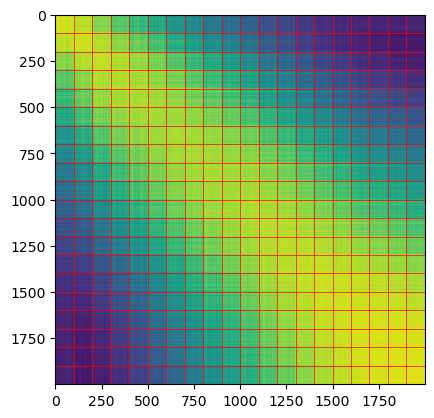

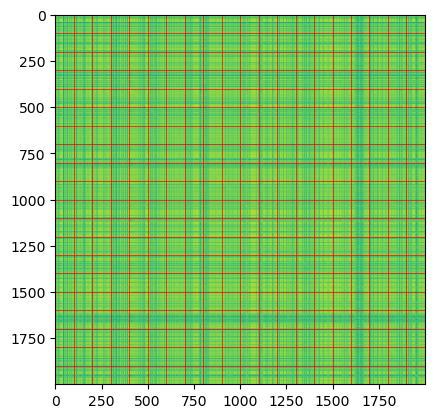

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Plot the similarity structure of the embeddings.
pooled_xs = pooled[-1].detach().numpy()
n_objects = ys.argmax(1)
sort_idx = n_objects.argsort()
xs_sorted = pooled_xs[sort_idx]
n_objects = n_objects[sort_idx]
sim_mat = cosine_similarity(xs_sorted, xs_sorted)
plt.imshow(sim_mat)
plt.axis('off')
# Draw lines to separate the different classes.
for i in range(1, n_objects.max()+1):
    plt.axvline(i*100, color='r', linewidth=0.5)
    plt.axhline(i*100, color='r', linewidth=0.5)
plt.show()

# Plot the similarity structure of the embeddings.
sort_idx = n_objects.argsort()
xs_sorted = xs[sort_idx].mean(1).detach().numpy()
n_objects = n_objects[sort_idx]
new_sim_mat = cosine_similarity(xs_sorted, xs_sorted)
plt.imshow(new_sim_mat)
plt.axis('off')
# Draw lines to separate the different classes.
for i in range(1, n_objects.max()+1):
    plt.axvline(i*100, color='r', linewidth=0.5)
    plt.axhline(i*100, color='r', linewidth=0.5)

#### Plot how similar each n_objects is with other n_objects (increased similarity with more objects?)

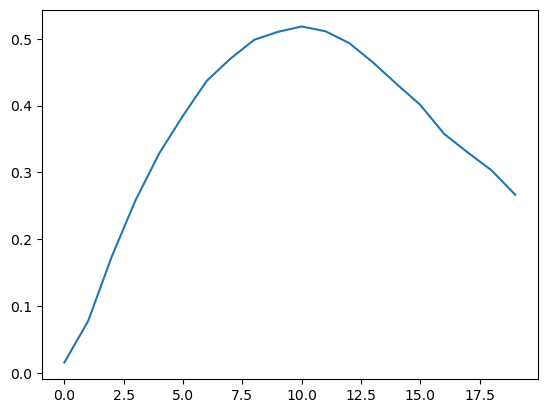

In [46]:
plt.plot(sim_mat.reshape(20, 100, 2000).mean((1,2)))

#### Now DINOv2

In [ ]:
# Load the environment and the dataset.
batch_size = 1
cfg = setup()
task = instantiate(cfg.task)
dataset = ImageDataset(task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

In [ ]:
targets = []
embs = []
for (xs, ys) in tqdm(dataloader):
    with torch.no_grad():
        inputs = processor(images=xs.to(device), return_tensors='pt', do_rescale=False)
        img_emb = model(**inputs).last_hidden_state
        embs.append(img_emb)
        targets.append(ys)

### Project ideas:
##### 1. Are shapes or colors more easily decodable from VLMs? (the result may surprise you!)
##### 2. Signatures of compositional feature representations in CLIP? (i.e. replicate and extend [Lewis et al 2022](https://arxiv.org/abs/2212.10537) using TPR probes).
##### 3. 